In [2]:
pip install langchain_openai langchain_core langchain_community langgraph langchain-couchbase langgraph-checkpointer-couchbase langchain-aws langchain-tavily boto3

Note: you may need to restart the kernel to use updated packages.


In [3]:
import os
from typing import List, Dict, Any, Literal
from typing_extensions import TypedDict
from dotenv import load_dotenv

load_dotenv()

class RealEstateAgentState(TypedDict):
    messages: List[Dict[str, Any]] 
    user_query: str                 
    search_results: List[Dict[str, Any]]  
    buyer_profile: Dict[str, Any]    
    next_action: str                

In [4]:
from datetime import timedelta
from couchbase.auth import PasswordAuthenticator
from couchbase.cluster import Cluster
from couchbase.options import ClusterOptions
from langchain_aws import BedrockEmbeddings, ChatBedrock
from langchain_couchbase.vectorstores import CouchbaseSearchVectorStore
from langchain_tavily import TavilySearch
import json

llm = ChatBedrock(
    model_id="us.meta.llama4-maverick-17b-instruct-v1:0",
    region_name=os.getenv("AWS_REGION", "us-east-2"),
    temperature=0.7
)

embeddings = BedrockEmbeddings(model_id="amazon.titan-embed-text-v2:0")

auth = PasswordAuthenticator(os.getenv("CB_USERNAME"), os.getenv("CB_PASSWORD"))
options = ClusterOptions(auth)
cluster = Cluster(os.getenv("CB_HOSTNAME"), options)
cluster.wait_until_ready(timedelta(seconds=5))

BUCKET = "properties"
SCOPE = "2025-listings"
COLLECTION = "united-states"
SEARCH_INDEX = "properties-index"

vector_store = CouchbaseSearchVectorStore(
    cluster=cluster,
    bucket_name=BUCKET,
    scope_name=SCOPE,
    collection_name=COLLECTION,
    embedding=embeddings,
    index_name=SEARCH_INDEX,
    text_key="description",
    embedding_key="embedding",
)

tavily_search = TavilySearch(max_results=3)

In [5]:
def couchbase_property_search(query: str, k: int = 5) -> List[Dict[str, Any]]:
    """Search properties in Couchbase using vector similarity"""
    try:
        results = vector_store.similarity_search_with_score(query, k=k)
        properties = []
        for doc, score in results:
            property_data = {
                "name": doc.metadata.get('name', 'Unknown Property'),
                "price": doc.metadata.get('price', 'Price not available'),
                "address": doc.metadata.get('address', 'Address not available'),
                "bedrooms": doc.metadata.get('bedrooms', 'N/A'),
                "bathrooms": doc.metadata.get('bathrooms', 'N/A'),
                "house_sqft": doc.metadata.get('house_sqft', 'N/A'),
                "description": doc.page_content,
                "similarity_score": round(score, 3)
            }
            properties.append(property_data)
        return properties
    except Exception as e:
        print(f"Couchbase search error: {e}")
        return []

def tavily_market_search(query: str) -> List[Dict[str, Any]]:
    """Search market information using Tavily"""
    try:
        results = tavily_search.invoke(f"San Diego real estate {query}")
        return results if isinstance(results, list) else []
    except Exception as e:
        print(f"Tavily search error: {e}")
        return []

def load_buyer_profile(buyer_name: str) -> Dict[str, Any]:
    """Load buyer profile from JSON file"""
    try:
        with open("/Users/jake.wood/Documents/americas-ai-challenge/data-models/profiles/buyers.json", "r") as f:
            profiles = json.load(f)
            for profile in profiles:
                if profile.get("buyer", "").lower() == buyer_name.lower():
                    return profile
        return {}
    except Exception as e:
        print(f"Error loading buyer profile: {e}")
        return {}

In [6]:
def analyze_user_intent(state: RealEstateAgentState) -> RealEstateAgentState:
    """Analyze user intent and determine next action"""
    print("Analyzing user intent...")
    
    user_query = state.get("user_query", "").lower()

    property_keywords = ["house", "home", "property", "bedroom", "bathroom", "price", "buy", "purchase", "condo", "apartment"]
    market_keywords = ["market", "trends", "prices", "neighborhood", "area", "schools", "crime", "demographics"]
    
    is_property_search = any(keyword in user_query for keyword in property_keywords)
    is_market_search = any(keyword in user_query for keyword in market_keywords)
    
    if is_property_search:
        next_action = "property_search"
    elif is_market_search:
        next_action = "market_search"
    else:
        next_action = "general_chat"
    
    state["next_action"] = next_action
    return state

def property_search_node(state: RealEstateAgentState) -> RealEstateAgentState:
    """Search for properties using Couchbase vector search"""
    print("Searching properties in Couchbase...")
    
    user_query = state.get("user_query", "")
    buyer_profile = state.get("buyer_profile", {})
    
    search_query = user_query
    if buyer_profile:
        budget = buyer_profile.get("budget", {})
        bedrooms = buyer_profile.get("bedrooms")
        location = buyer_profile.get("location")
        
        if budget:
            search_query += f" budget ${budget.get('min', 0)}-${budget.get('max', 0)}"
        if bedrooms:
            search_query += f" {bedrooms} bedrooms"
        if location:
            search_query += f" in {location}"
    
    properties = couchbase_property_search(search_query, k=5)
    state["search_results"] = properties
    
    return state

def market_search_node(state: RealEstateAgentState) -> RealEstateAgentState:
    """Search for market information using Tavily"""
    print("Searching market information...")
    
    user_query = state.get("user_query", "")
    market_info = tavily_market_search(user_query)
    state["search_results"] = market_info
    
    return state

def general_chat_node(state: RealEstateAgentState) -> RealEstateAgentState:
    """Handle general conversation using LLM"""
    print("Engaging in general conversation...")
    
    user_query = state.get("user_query", "")
    
    system_prompt = """You are a friendly, professional real estate agent. 
    Help users with general real estate questions and guide them toward finding their dream property.
    Be conversational and ask follow-up questions to understand their needs better."""
    
    response = llm.invoke([
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": user_query}
    ])
    
    state["search_results"] = [{"type": "chat_response", "content": response.content}]
    return state

def format_response_node(state: RealEstateAgentState) -> RealEstateAgentState:
    """Format the final response based on search results"""
    print("Formatting response...")
    
    search_results = state.get("search_results", [])
    next_action = state.get("next_action", "")
    
    if next_action == "property_search" and search_results:

        formatted_response = "🏠 **Found these properties for you:**\n\n"
        for i, prop in enumerate(search_results[:3], 1):
            formatted_response += f"**{i}. {prop['name']} - {prop['price']}**\n"
            formatted_response += f"📍 {prop['address']}\n"
            formatted_response += f"🛏️ {prop['bedrooms']}bd/{prop['bathrooms']}ba • {prop['house_sqft']} sqft\n"
            formatted_response += f"📝 {prop['description'][:200]}...\n"
            formatted_response += f"🎯 Similarity: {prop['similarity_score']}\n\n"
    
    elif next_action == "market_search" and search_results:
        formatted_response = "**Market Information:**\n\n"
        for item in search_results[:2]:
            formatted_response += f"• {item.get('content', item.get('title', 'Market info'))}\n\n"
    
    elif search_results and search_results[0].get("type") == "chat_response":
        formatted_response = search_results[0]["content"]
    
    else:
        formatted_response = "I'd be happy to help you find your dream property! Can you tell me more about what you're looking for?"
    
    messages = state.get("messages", [])
    messages.append({"role": "assistant", "content": formatted_response})
    state["messages"] = messages
    
    return state

In [7]:
def route_decision(state: RealEstateAgentState) -> Literal["property_search", "market_search", "general_chat"]:
    """Route to appropriate tool based on user intent"""
    next_action = state.get("next_action", "general_chat")
    print(f"Routing to: {next_action}")
    return next_action

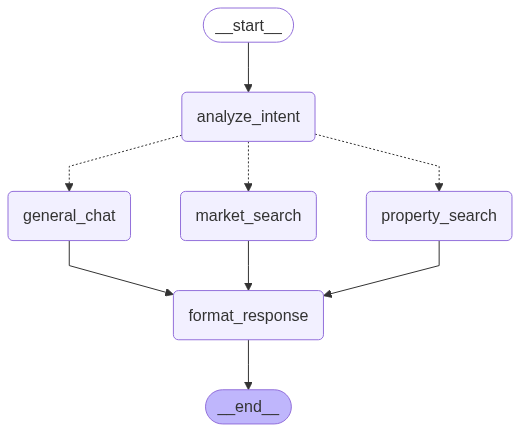

In [8]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

builder = StateGraph(RealEstateAgentState)

builder.add_node("analyze_intent", analyze_user_intent)
builder.add_node("property_search", property_search_node)
builder.add_node("market_search", market_search_node)
builder.add_node("general_chat", general_chat_node)
builder.add_node("format_response", format_response_node)

builder.add_edge(START, "analyze_intent")
builder.add_conditional_edges(
    "analyze_intent", 
    route_decision,
    {
        "property_search": "property_search",
        "market_search": "market_search", 
        "general_chat": "general_chat"
    }
)
builder.add_edge("property_search", "format_response")
builder.add_edge("market_search", "format_response")
builder.add_edge("general_chat", "format_response")
builder.add_edge("format_response", END)

real_estate_agent = builder.compile()

try:
    display(Image(real_estate_agent.get_graph().draw_mermaid_png()))

except Exception as e:
    print(f"Graph created successfully! (Visualization error: {e})")

In [9]:
def test_agent(query: str, buyer_name: str = None):
    """Test the real estate agent with a query"""
    print(f"\nUser Query: '{query}'")
    print("=" * 60)

    buyer_profile = {}
    if buyer_name:
        buyer_profile = load_buyer_profile(buyer_name)
        if buyer_profile:
            print(f"Loaded profile for {buyer_profile.get('buyer', buyer_name)}")

    initial_state = RealEstateAgentState(
        messages=[{"role": "user", "content": query}],
        user_query=query,
        search_results=[],
        buyer_profile=buyer_profile,
        next_action=""
    )
    
    result = real_estate_agent.invoke(initial_state)
    
    final_message = result["messages"][-1]["content"]
    print(f"\nAgent Response:\n{final_message}")
    print("\n" + "=" * 60)
    
    return result

print(" Ready to test the Real Estate Agent!")
print("\nTry these examples:")
print("• test_agent('I want a beautiful beachside property with a nice backyard')")
print("• test_agent('What are current market trends in San Diego?')")  
print("• test_agent('Looking for a 3 bedroom house under $1.2M', 'Jake Wood')")
print("• test_agent('Tell me about Del Mar real estate prices')")
print("• test_agent('I need help finding my first home')")

 Ready to test the Real Estate Agent!

Try these examples:
• test_agent('I want a beautiful beachside property with a nice backyard')
• test_agent('What are current market trends in San Diego?')
• test_agent('Looking for a 3 bedroom house under $1.2M', 'Jake Wood')
• test_agent('Tell me about Del Mar real estate prices')
• test_agent('I need help finding my first home')


In [10]:
result1 = test_agent('I want a beautiful beachside property with a nice backyard', 'Jake Wood')


User Query: 'I want a beautiful beachside property with a nice backyard'
Loaded profile for Jake Wood
Analyzing user intent...
Routing to: property_search
Searching properties in Couchbase...
Formatting response...

Agent Response:
🏠 **Found these properties for you:**

**1. Encinitas Beach Town Bungalow - $945,000**
📍 468 2nd St, Encinitas, CA 92024
🛏️ 3bd/2ba • 1550 sqft
📝 Charming 3-bedroom beach bungalow in the heart of Encinitas. Recently updated with modern amenities while preserving original character. Private backyard with fruit trees, walking distance to Moonligh...
🎯 Similarity: 0.298

**2. Luxury Downtown Penthouse - $2,850,000**
📍 1234 1st Ave, San Diego, CA 92101
🛏️ 3bd/3ba • 2500 sqft
📝 Stunning 3-bedroom penthouse in the heart of downtown San Diego. Floor-to-ceiling windows with panoramic bay and city views. High-end finishes throughout including marble bathrooms and chef's kitchen....
🎯 Similarity: 0.291

**3. Mission Bay Waterfront Condo - $1,150,000**
📍 1234 Bay View

In [11]:
result2 = test_agent('What are current market trends in San Diego?')


User Query: 'What are current market trends in San Diego?'
Analyzing user intent...
Routing to: market_search
Searching market information...
Formatting response...

Agent Response:
I'd be happy to help you find your dream property! Can you tell me more about what you're looking for?



In [12]:
result3 = test_agent('I need help finding my first home')


User Query: 'I need help finding my first home'
Analyzing user intent...
Routing to: property_search
Searching properties in Couchbase...
Formatting response...

Agent Response:
🏠 **Found these properties for you:**

**1. Affordable Starter Home - $649,000**
📍 5432 Elm St, Chula Vista, CA 91910
🛏️ 3bd/2ba • 1150 sqft
📝 Cozy 3-bedroom starter home in Chula Vista with great potential. Needs some TLC but perfect for buyers looking to build equity. Large lot with fruit trees and room for expansion. Close to schools and ...
🎯 Similarity: 0.231

**2. Suburban Family Home - $849,000**
📍 9876 Meadow Dr, San Diego, CA 92126
🛏️ 4bd/3ba • 2200 sqft
📝 Spacious 4-bedroom family home in quiet Mira Mesa neighborhood. Large backyard with pool, updated kitchen with granite counters, and formal dining room. Great schools and family-friendly community....
🎯 Similarity: 0.167

**3. Kensington Spanish Revival - $875,000**
📍 5678 Adams Ave, San Diego, CA 92116
🛏️ 3bd/2ba • 1650 sqft
📝 Charming Spanish-styl

In [13]:
result4 = test_agent('Looking for a spacious family home', 'Kevin Farley')


User Query: 'Looking for a spacious family home'
Loaded profile for Kevin Farley
Analyzing user intent...
Routing to: property_search
Searching properties in Couchbase...
Formatting response...

Agent Response:
🏠 **Found these properties for you:**

**1. Suburban Family Home - $849,000**
📍 9876 Meadow Dr, San Diego, CA 92126
🛏️ 4bd/3ba • 2200 sqft
📝 Spacious 4-bedroom family home in quiet Mira Mesa neighborhood. Large backyard with pool, updated kitchen with granite counters, and formal dining room. Great schools and family-friendly community....
🎯 Similarity: 0.264

**2. Affordable Starter Home - $649,000**
📍 5432 Elm St, Chula Vista, CA 91910
🛏️ 3bd/2ba • 1150 sqft
📝 Cozy 3-bedroom starter home in Chula Vista with great potential. Needs some TLC but perfect for buyers looking to build equity. Large lot with fruit trees and room for expansion. Close to schools and ...
🎯 Similarity: 0.244

**3. Fremont Craftsman Family Home - $1,285,000**
📍 4512 Fremont Ave N, Seattle, WA 98103
🛏️ 4bd